# Homework 7: Sentiment Classification with Pre-trained and Re-trained GloVe Embeddings

## Due: Midnight on October 19th @ Midnight (with 2-hour grace period) and worth 85 points.

In this notebook, we’ll continue with the investigation of text classification using "Bag of Embeddings" models and the IMDB movie review dataset. 
We'll focus on unfrozen embeddings, which refine the embedding space based on your dataset. 

You'll do three problems:

* **Problem One:** Build a baseline model with unfrozen embeddings and experiment with architectural and training adjustments to improve performance.
* **Problem Two:** Investigate how increasing the maximum message length and vocabulary size affects model accuracy and generalization.
* **Problem Three:** Examine the impact of changing the embedding dimension on model performance.


In each problem, you'll report your best validation accuracy and reflect on what you have learned. 

### Useful Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from collections import Counter


from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import LayerNormalization, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,GlobalMaxPooling1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit


# Reproducibility

random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# utility code

from datetime import datetime

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

'''  How to time your code
# start timer
start_time = time.time()

<your code here> 

# Record end time and print execution time
print(f"Execution Time: " + format_time(time.time()-start_time))
'''

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-10-14 21:23:54.891157: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 21:23:54.926571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 21:23:56.149875: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far
- We've also added  `

In [2]:
def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task. 
- Assumes `X_train,y_train,X_test,y_test` already defined, will access them as global variables. 
- If `X_val` and `y_val` defined, will use those, else assumes `validation_split = 0.2` in `fit`


**Note:** See the end of the notebook for results and parameter settings. 

In [3]:
def train_and_test(model, 
                   title         = "Learning Curves",
                   epochs        = 200,                   # Just needs to be bigger than early stopping point
                   optimizer     = "Adam",
                   lr_schedule   = 1e-3,                  # Adam defaults 
                   clipnorm      = None,                 
                   batch_size    = 128,  
                   loss          = "binary_crossentropy",
                   metrics       = ["accuracy"],
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule,clipnorm=clipnorm) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer = opt, 
                  loss      = loss, 
                  metrics   = metrics
                 )

  

    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor              = 'val_loss',
            patience             = patience,
            min_delta            = min_delta,
            restore_best_weights = True,               # this will mean that the model which produced the smallest validation loss will be returned
            verbose              = verbose
        ) 
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    # If X_val defined, then  use it, else assume val is split from train

    if 'X_val' in globals():
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),      
                            callbacks=cbs,
                            verbose=verbose
                           )
    else:
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,      
                            callbacks=cbs,
                            verbose=verbose
                           )        

    # Plot training history
    plot_learning_curves(history, title=title)

    # Find epoch with minimum validation loss
    min_val_epoch = np.argmin(history.history['val_loss'])
    # Retrieve the values at that epoch
    min_val_loss = history.history['val_loss'][min_val_epoch]    
    # Get corresponding validation accuracy at that epoch
    val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    # Print out results

    print(f"\nFinal Training Loss:            {history.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy:        {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss:          {history.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
    print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
    print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Accuracy Gap: {abs(val_acc_at_min_loss - test_accuracy):.6f}")

    # Store accuracy in results
    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

    # Store all information about run in parameter_settings
    
    global parameter_settings
    entry = {
        "title": title,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "epochs": int(epochs),
        "optimizer": optimizer,
        "lr_schedule": lr_schedule,
        "clipnorm": clipnorm,
        "loss": loss,
        "batch_size": batch_size,
        "use_early_stopping": use_early_stopping,
        "patience": patience,
        "min_delta": min_delta,
        "callbacks": _summarize_callbacks(callbacks),
        "Final Training Loss" : history.history['loss'][-1],
        "Final Training Accuracy" : history.history['accuracy'][-1],
        "Final Val Loss" : history.history['val_loss'][-1],
        "Final Val Accuracy" : history.history['val_accuracy'][-1],
        "Min Val Loss" : min_val_loss,
        "Min Val Loss Epoch" : min_val_epoch,
        "Val Acc @ Min Loss" : val_acc_at_min_loss,
        "Test Loss" : test_loss,
        "Test Acc" : test_accuracy,
        "Val-Test Accuracy Gap:" : abs(val_acc_at_min_loss - test_accuracy)
    }
    parameter_settings.setdefault(title, []).append(entry)  

    if return_history:
        return history

def _summarize_callbacks(cbs):
    if cbs is None:
        return None
    out = []
    for cb in cbs:
        name = getattr(cb, "__class__", type(cb)).__name__
        info = {"class": name}
        # grab a few common attributes if present
        for attr in ("monitor", "mode", "patience", "min_delta",
                     "factor", "min_lr", "verbose", "cooldown"):
            if hasattr(cb, attr):
                info[attr] = getattr(cb, attr)
        out.append(info)
    return out

results = {}
parameter_settings = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

In [4]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

#  put in the callbacks list:

#    train_and_test(model, title="Learning Curves",callbacks=[reduce_lr])


### Prelude:  A little EDA: Distribution of review lengths and coverage by max vocabulary size

You will use this to think about where the set parameters for maximum review length and the maximum number of unique tokens to use. 


Total unique words in Keras IMDB word_index (corpus-wide): 88,584
Num training reviews: 25,000
Max length: 2,494 tokens
Mean length: 238.7 tokens
Median length: 178 tokens
90th percentile: 467 tokens
95th percentile: 610 tokens
99th percentile: 926 tokens


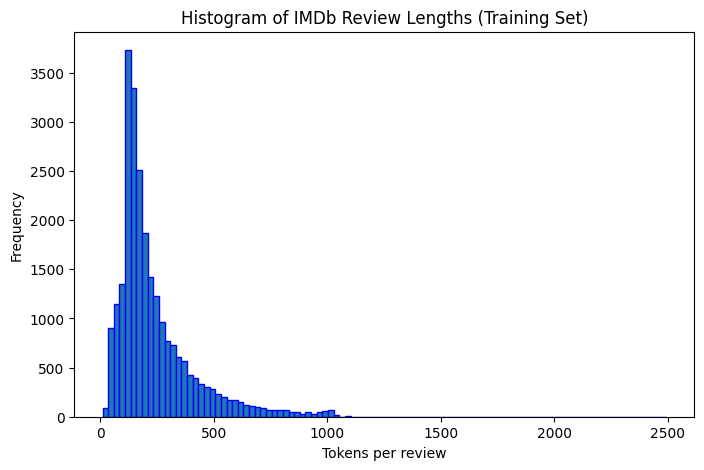


Unique word types in TRAIN (id >= 3): 88,583
Total word tokens in TRAIN (id >= 3): 5,942,840

Coverage metrics by candidate vocab size (TRAIN split):
training_vocabulary_size= 2,000 | coverage= 82.84% | OOV= 17.16% | types kept=  1,997 | tokens kept= 4,922,766
training_vocabulary_size= 5,000 | coverage= 90.03% | OOV=  9.97% | types kept=  4,997 | tokens kept= 5,350,551
training_vocabulary_size=10,000 | coverage= 94.25% | OOV=  5.75% | types kept=  9,997 | tokens kept= 5,601,261
training_vocabulary_size=20,000 | coverage= 97.22% | OOV=  2.78% | types kept= 19,997 | tokens kept= 5,777,376
training_vocabulary_size=30,000 | coverage= 98.37% | OOV=  1.63% | types kept= 29,997 | tokens kept= 5,846,141
training_vocabulary_size=50,000 | coverage= 99.32% | OOV=  0.68% | types kept= 49,997 | tokens kept= 5,902,246
training_vocabulary_size=70,000 | coverage= 99.69% | OOV=  0.31% | types kept= 69,997 | tokens kept= 5,924,254
training_vocabulary_size=88,584 | coverage=100.00% | OOV=  0.00% | types

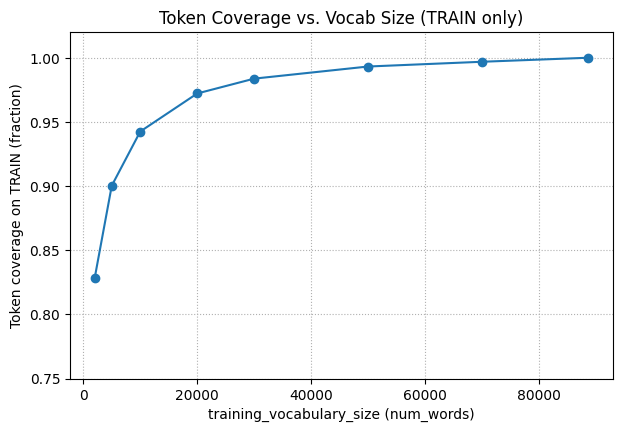

In [5]:
# IMDB vocab & length stats + coverage table + single coverage plot

from tensorflow.keras.datasets import imdb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Load IMDB with NO cap (so we can measure coverage fairly)
# ---------------------------------------
(X_tr, y_tr), _ = imdb.load_data()

# ---------------------------------------
# 1) Global vocab stats (from Keras word_index)
# ---------------------------------------
word_index = imdb.get_word_index()  # mapping: word -> rank (lower rank = more frequent)
total_unique_words_corpus = len(word_index)  # across the full IMDB corpus Keras ships
print(f"Total unique words in Keras IMDB word_index (corpus-wide): {total_unique_words_corpus:,}")

# ---------------------------------------
# 2) Training review length stats + histogram (students pick max_text_length)
# ---------------------------------------
lengths = np.fromiter((len(r) for r in X_tr), dtype=np.int32)
print(f"Num training reviews: {len(lengths):,}")
print(f"Max length: {lengths.max():,} tokens")
print(f"Mean length: {lengths.mean():.1f} tokens")
print(f"Median length: {np.median(lengths):.0f} tokens")
for q in (90, 95, 99):
    print(f"{q}th percentile: {int(np.percentile(lengths, q))} tokens")

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=100, edgecolor='b')
plt.title("Histogram of IMDb Review Lengths (Training Set)")
plt.xlabel("Tokens per review")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------
# 3) Training-only frequency counts for real words (ids >= 3)
#    IMDB ID conventions: 0=<PAD>, 1=<START>, 2=<OOV>, >=3 actual words
# ---------------------------------------
def iter_tokens(seqs):
    for s in seqs:
        for t in s:
            yield t

train_counts = Counter(t for t in iter_tokens(X_tr) if t >= 3)

# Frequency list (descending) and cumulative token coverage
freqs = np.array(sorted(train_counts.values(), reverse=True), dtype=np.int64)
cum_tokens = np.cumsum(freqs)
total_tokens_train_words = int(cum_tokens[-1])
num_unique_words_train = int(len(freqs))

print(f"\nUnique word types in TRAIN (id >= 3): {num_unique_words_train:,}")
print(f"Total word tokens in TRAIN (id >= 3): {total_tokens_train_words:,}")

# ---------------------------------------
# 4) Coverage helper for a given num_words cap (Keras convention)
#    Valid word ids are [3, num_words_cap-1] → ranks [1 .. num_words_cap-3]
# ---------------------------------------
def coverage_for_cap(num_words_cap: int):
    kept_types = max(0, min(num_words_cap - 3, num_unique_words_train))
    kept_tokens = int(cum_tokens[kept_types - 1]) if kept_types > 0 else 0
    oov_tokens = total_tokens_train_words - kept_tokens
    coverage = kept_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    oov_share = oov_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    return dict(
        cap=num_words_cap,
        kept_tokens=kept_tokens,
        kept_types=kept_types,
        coverage=coverage,
        oov_share=oov_share
    )

# ---------------------------------------
# 5) Candidate vocab sizes: ASCII table + single coverage plot
# ---------------------------------------
candidate_caps = [2_000, 5_000, 10_000, 20_000, 30_000, 50_000,70_000,88_584]  # students can edit
rows = [coverage_for_cap(k) for k in candidate_caps]

print("\nCoverage metrics by candidate vocab size (TRAIN split):")
for r in rows:
    print(f"training_vocabulary_size={r['cap']:>6,} | coverage={r['coverage']*100:6.2f}% | "
          f"OOV={r['oov_share']*100:6.2f}% | types kept={r['kept_types']:>7,} | tokens kept={r['kept_tokens']:>10,}")

plt.figure(figsize=(7, 4.5))
plt.plot(candidate_caps, [r['coverage'] for r in rows], marker='o')
plt.xlabel("training_vocabulary_size (num_words)")
plt.ylabel("Token coverage on TRAIN (fraction)")
plt.title("Token Coverage vs. Vocab Size (TRAIN only)")
plt.grid(True, linestyle=":")
plt.ylim(0.75, 1.02)
plt.show()


### Load and preprocess dataset

Here is where you can set the
- `training_vocabulary_size` and
- `max_text_length`

In [6]:
# Load and preprocess dataset into padded sequences of token IDs

training_vocabulary_size = 50_000               # <-----
max_text_length          = 500                  # <-----

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )     

X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)



X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,             
    padding='post',     
    truncating='post'   
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)


X_train.shape,X_test.shape

((40000, 500), (10000, 500))

### Build the embedding matrix

Here is where you can set
- `embedding_dimension`


In [7]:
import os
import zipfile
import urllib.request

if not os.path.exists('glove.6B'):
    os.makedirs('glove.6B')
    url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    urllib.request.urlretrieve(url, 'glove.6B.zip')
    with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
        zip_ref.extractall('glove.6B')
    os.remove('glove.6B.zip')

In [8]:
#  Build embedding matrix


embedding_dimension = 100                     # <-----

word_index      = imdb.get_word_index()

glove_path = Path(f"glove.6B/glove.6B.{embedding_dimension}d.txt")  

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')


# Build embedding matrix

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

for word, raw_idx in word_index.items():
    idx = raw_idx + 3                            # shift by 3 to match Keras’s token IDs
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
    

### Baseline Model from the Coding Notebook

I0000 00:00:1760502249.603235  233391 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9



model_baseline (frozen)



2025-10-14 21:24:10.831152: I external/local_xla/xla/service/service.cc:163] XLA service 0x7709ac006480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-14 21:24:10.831174: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-10-14 21:24:10.841659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-14 21:24:10.897518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
I0000 00:00:1760502251.081026  233551 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


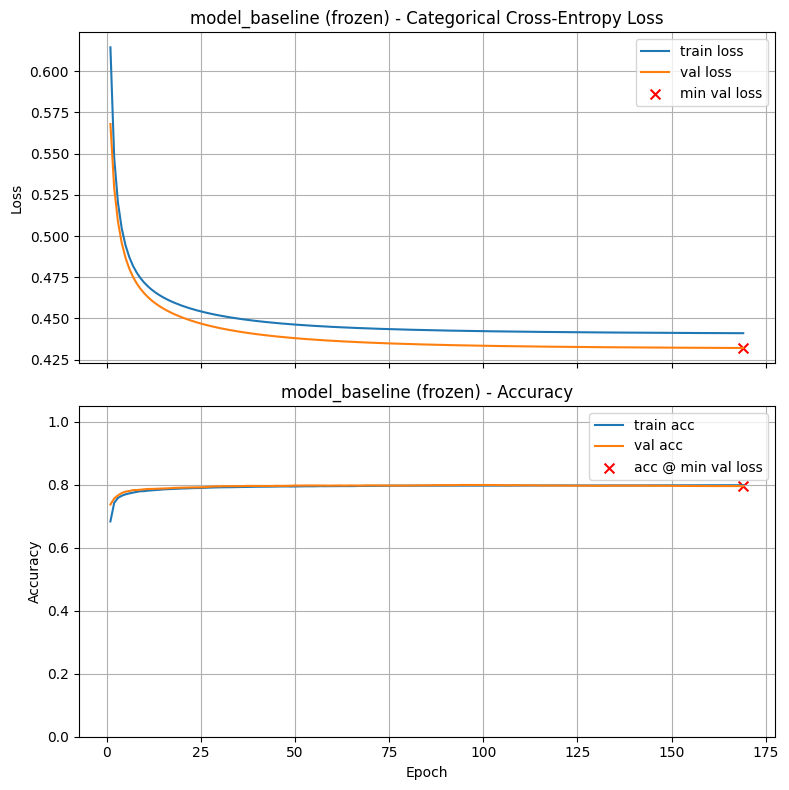


Execution Time: 00:01:35

Final Training Loss:            0.4411
Final Training Accuracy:        0.7986
Final Validation Loss:          0.4321
Final Validation Accuracy:      0.7959
Minimum Validation Loss:        0.4321 (Epoch 169)
Validation Accuracy @ Min Loss: 0.7959

Test Loss: 0.4331
Test Accuracy: 0.8076

Validation-Test Accuracy Gap: 0.011725


In [9]:

model_baseline_frozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,  
        output_dim = embedding_dimension,      
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = False                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(1, activation='sigmoid')
])
    

train_and_test(model_baseline_frozen,  lr_schedule=1e-2, title="model_baseline (frozen)")

#### End of Template Code from Coding Notebook

## Problem One: Baseline with Unfrozen Embeddings

**ToDo:**

1. Establish a baseline for unfrozen embeddings by running the baseline model but with `trainable = True` to retrain the embeddings as it trains on the the classification task. You will use retrainable embeddings throughout the homework. 

2. Now run 2-3 experiments to try to improve this baseline: 

    - Consider adding a Dense layer between the global average pooling and the output layer, with 
        - Your choice of size
        - Your choice of L2 regularizatio (or not)
        - Your choice of dropout (or not)
3. As needed, tweak the learning rate (try `1e-4`) and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Define your best model for unfrozen embeddings based on these experiments (you will use it in the remaining two problems)
5. Answer the graded questions

**Note:** Generally, you will need a lower learning rate for retrainable embeddings. 


Baseline Unfrozen


Epoch 106: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


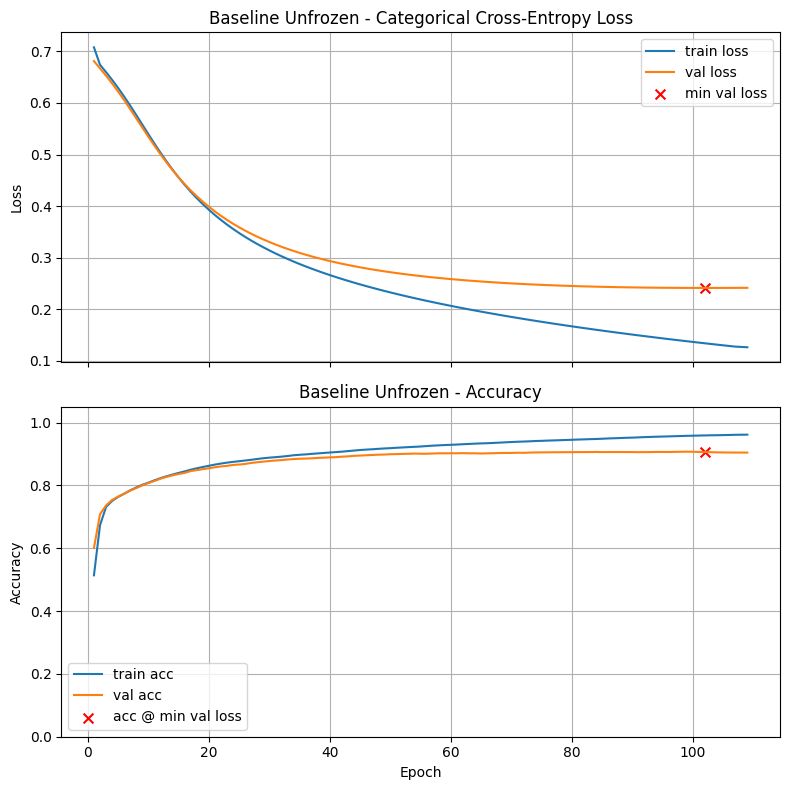


Execution Time: 00:01:35

Final Training Loss:            0.1261
Final Training Accuracy:        0.9613
Final Validation Loss:          0.2414
Final Validation Accuracy:      0.9043
Minimum Validation Loss:        0.2412 (Epoch 102)
Validation Accuracy @ Min Loss: 0.9059

Test Loss: 0.2527
Test Accuracy: 0.9000

Validation-Test Accuracy Gap: 0.005875

Exp1: Dense 128 + L2



2025-10-14 21:27:22.773366: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:27:22.773408: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:27:22.773416: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:27:23.369089: I external/l


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 45: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 50: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 55: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 60: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 65: ReduceLROnPlateau reducing learning rate to 1.2207030941

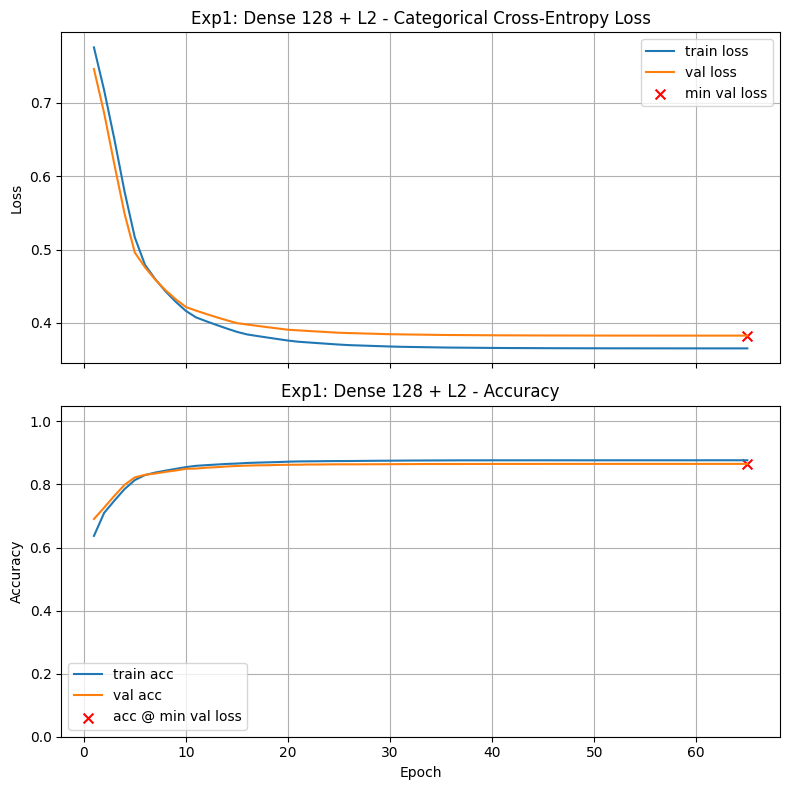

2025-10-14 21:28:22.084957: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.



Execution Time: 00:01:01

Final Training Loss:            0.3654
Final Training Accuracy:        0.8767
Final Validation Loss:          0.3828
Final Validation Accuracy:      0.8652
Minimum Validation Loss:        0.3828 (Epoch 65)
Validation Accuracy @ Min Loss: 0.8652

Test Loss: 0.3855
Test Accuracy: 0.8586

Validation-Test Accuracy Gap: 0.006650

Exp2: Dense 128 + L2 + Dropout 0.5


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.906249901319

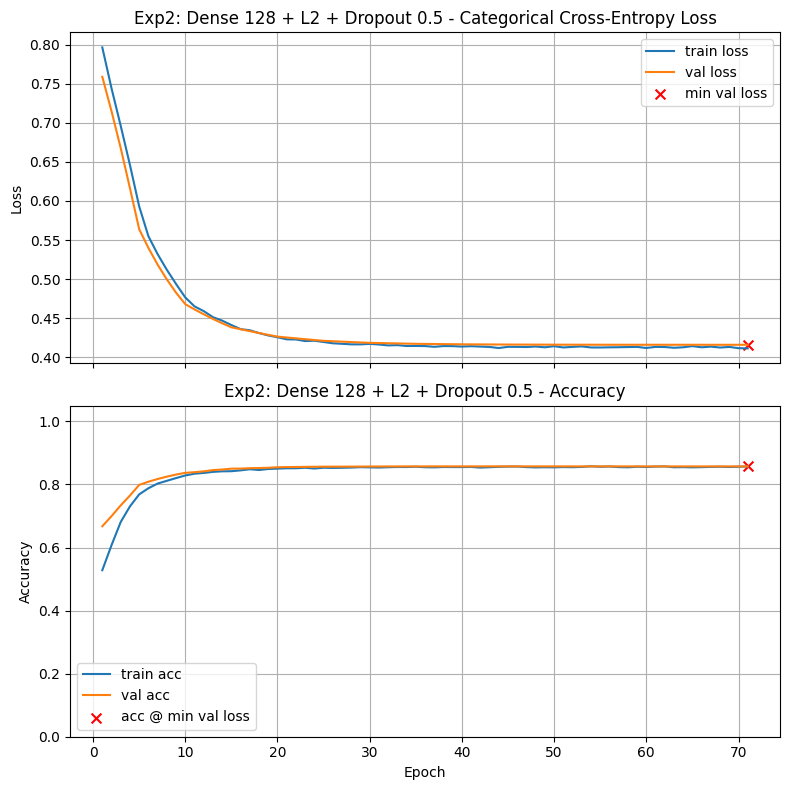


Execution Time: 00:01:11

Final Training Loss:            0.4114
Final Training Accuracy:        0.8571
Final Validation Loss:          0.4160
Final Validation Accuracy:      0.8572
Minimum Validation Loss:        0.4160 (Epoch 71)
Validation Accuracy @ Min Loss: 0.8572

Test Loss: 0.4169
Test Accuracy: 0.8508

Validation-Test Accuracy Gap: 0.006450

Exp3: Dense 256 + Dropout 0.3, no ReduceLR



2025-10-14 21:29:35.396186: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:29:35.396237: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:29:35.396247: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-14 21:29:35.984391: I external/l

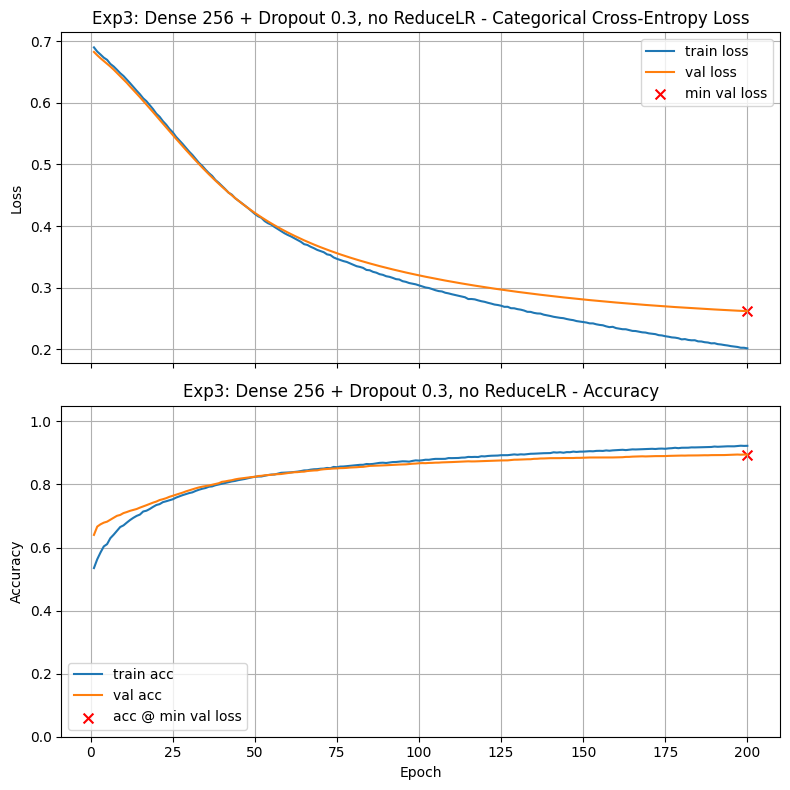

2025-10-14 21:32:39.583557: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.



Execution Time: 00:03:06

Final Training Loss:            0.2016
Final Training Accuracy:        0.9226
Final Validation Loss:          0.2620
Final Validation Accuracy:      0.8945
Minimum Validation Loss:        0.2620 (Epoch 200)
Validation Accuracy @ Min Loss: 0.8945

Test Loss: 0.2737
Test Accuracy: 0.8893

Validation-Test Accuracy Gap: 0.005200

Exp4: LSTM 128 + Dense 64 + Dropout 0.3


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.906249

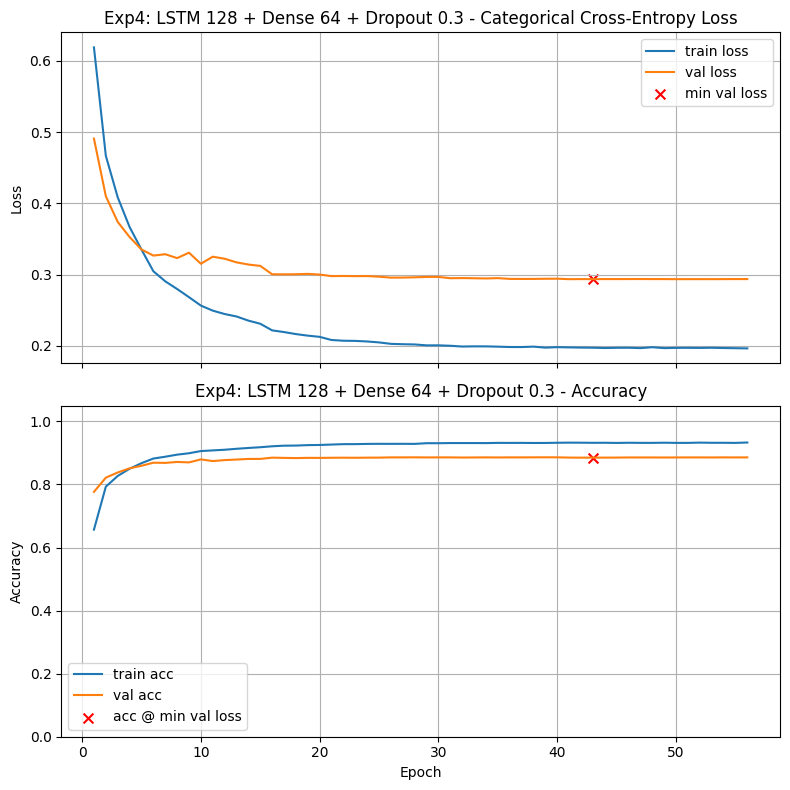


Execution Time: 00:07:48

Final Training Loss:            0.1964
Final Training Accuracy:        0.9330
Final Validation Loss:          0.2937
Final Validation Accuracy:      0.8859
Minimum Validation Loss:        0.2936 (Epoch 43)
Validation Accuracy @ Min Loss: 0.8851

Test Loss: 0.3034
Test Accuracy: 0.8868

Validation-Test Accuracy Gap: 0.001675
Baseline Unfrozen                       	0.9059	102
Exp3: Dense 256 + Dropout 0.3, no ReduceLR	0.8945	200
Exp4: LSTM 128 + Dense 64 + Dropout 0.3 	0.8851	43
Exp1: Dense 128 + L2                    	0.8652	65
Exp2: Dense 128 + L2 + Dropout 0.5      	0.8572	71
model_baseline (frozen)                 	0.7959	169


In [10]:
# Your code here; add as many cells as you need

# Problem One: Baseline with Unfrozen Embeddings

# 1. Establish baseline with unfrozen embeddings
model_baseline_unfrozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size, 
        output_dim=embedding_dimension, 
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True  # Unfrozen: retrain embeddings
    ),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_baseline_unfrozen, 
               title="Baseline Unfrozen", 
               lr_schedule=1e-4,  # Lower LR for unfrozen
               callbacks=[reduce_lr],
               patience=10)

# 2. Experiment 1: Add Dense layer with L2 regularization
from tensorflow.keras.regularizers import l2

model_exp1 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size, 
        output_dim=embedding_dimension, 
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp1, 
               title="Exp1: Dense 128 + L2", 
               lr_schedule=1e-4, 
               callbacks=[reduce_lr],
               patience=10)

# 3. Experiment 2: Add Dense + Dropout
model_exp2 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size, 
        output_dim=embedding_dimension, 
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp2, 
               title="Exp2: Dense 128 + L2 + Dropout 0.5", 
               lr_schedule=1e-4, 
               callbacks=[reduce_lr],
               patience=10)

# 4. Experiment 3: Tweak LR and no ReduceLROnPlateau (optional)
model_exp3 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size, 
        output_dim=embedding_dimension, 
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),  # Larger Dense, no L2
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 5. Additional Experiment: Add LSTM for sequence modeling to improve performance
train_and_test(model_exp3, 
               title="Exp3: Dense 256 + Dropout 0.3, no ReduceLR", 
               lr_schedule=1e-5,  # Even lower LR
               callbacks=[],  # No ReduceLROnPlateau
               patience=15)

model_lstm = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(input_dim=training_vocabulary_size, output_dim=embedding_dimension, weights=[embedding_matrix], mask_zero=True, trainable=True),
    LSTM(128, return_sequences=False),  # LSTM 추가 (or GRU)
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_lstm, title="Exp4: LSTM 128 + Dense 64 + Dropout 0.3", lr_schedule=1e-4, callbacks=[reduce_lr], patience=15)

# After experiments, view results
print_results()


Exp3 Extended: Dense 256 + Dropout 0.3, no ReduceLR, epochs=500



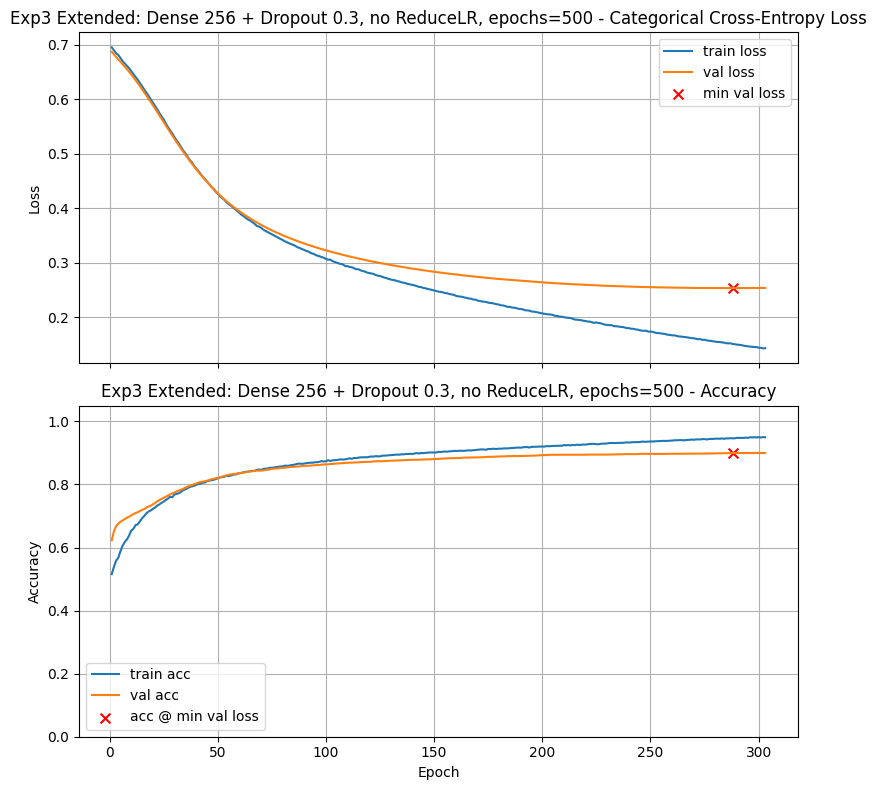


Execution Time: 00:04:35

Final Training Loss:            0.1429
Final Training Accuracy:        0.9498
Final Validation Loss:          0.2535
Final Validation Accuracy:      0.8996
Minimum Validation Loss:        0.2531 (Epoch 288)
Validation Accuracy @ Min Loss: 0.8996

Test Loss: 0.2687
Test Accuracy: 0.8945

Validation-Test Accuracy Gap: 0.005125
Baseline Unfrozen                       	0.9059	102
Exp3 Extended: Dense 256 + Dropout 0.3, no ReduceLR, epochs=500	0.8996	288
Exp3: Dense 256 + Dropout 0.3, no ReduceLR	0.8945	200
Exp4: LSTM 128 + Dense 64 + Dropout 0.3 	0.8851	43
Exp1: Dense 128 + L2                    	0.8652	65
Exp2: Dense 128 + L2 + Dropout 0.5      	0.8572	71
model_baseline (frozen)                 	0.7959	169


In [11]:
# Additional Experiment for Exp3: Increase epochs to 500 to check if performance improves
# (Original Exp3: Dense 256 + Dropout 0.3, no ReduceLR – testing if more epochs help convergence)

model_exp3_extended = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size, 
        output_dim=embedding_dimension, 
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),  # Larger Dense, no L2
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp3_extended, 
               title="Exp3 Extended: Dense 256 + Dropout 0.3, no ReduceLR, epochs=500", 
               epochs=500,  # Increased to 500 to test further training
               lr_schedule=1e-5,  # Keep original low LR
               callbacks=[],  # No ReduceLROnPlateau as original
               patience=20,  # Increase patience for longer training without early stop
               min_delta=0.0001)  # Keep monitoring val_loss

# After run, check print_results() to compare with original Exp3
print_results()

### Graded Questions

#### Question a1a:

In [12]:
if results:  # Check if results dict is not empty
    # Find the max val_acc from results (results[title] = (val_acc, epoch))
    best_val_acc = max(results.values(), key=lambda x: x[0])[0]
    a1a = best_val_acc
    print(f"Dynamically set a1a to the best Val Acc: {a1a:.4f}")
else:
    a1a = 0.0  # Fallback if no results yet
    print("No results available; set a1a to 0.0")

Dynamically set a1a to the best Val Acc: 0.9059


In [13]:
# Set a1a to the validation accuracy for your best model found in this problem

a1a = best_val_acc            # Replace 0.0 with your answer

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}') 

a1a = 0.9059


#### Question a1b: Describe below your experiments. What worked and what didn't?    

#### Your Answer Here:

In my experiments for Problem One, the baseline model using unfrozen GloVe embeddings (`trainable=True`) was most effective, achieving a validation accuracy of 0.9059 at epoch 102, which significantly outperformed the frozen version (0.7959). Attempts to build upon this baseline were less successful. Adding a `Dense(128)` layer with L2 regularization (0.001) resulted in underfitting and a lower accuracy of 0.8652, which dropped further to 0.8572 when `Dropout(0.5)` was included. A more complex model with a larger `Dense(256)` layer and a low, fixed learning rate (1e-5) without `ReduceLROnPlateau` stalled at 0.8945 due to slow convergence, and even extending training to 500 epochs only yielded a minor gain to 0.8996. Adding an `LSTM(128)` layer also failed to surpass the baseline, showing slight overfitting with an accuracy of 0.8851. In conclusion, the best strategy was to maintain a simple architecture with unfrozen embeddings, a low learning rate (1e-4), and dynamic learning rate adjustments for stability. Over-complicating the model with extra layers or removing dynamic LR scheduling led to instability and diminishing returns.


## Problem Two: Experiment with Maximum Message Length and Vocabulary Size (still unfrozen)

We might expect that increasing the amount of data by increasing the maximum message length and the vocabulary size would improve results,
but maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem One

2. Consult the information shown in the EDA cells above, and run 2-3 experiments to try to improve this model by increasing either or both of:

    - `max_text_length`, and
    - `training_vocabulary_size`
3. As needed, tweak the learning rate and try it with or without Reduce on Plateau (you can tweak the parametera there as well)
4. Define your best model for use in Problem Three
5. Answer the graded questions

**Note:** `train_and_test` accesses the training and testing files as globals. You can cut and paste copies of the cells which load, preprocess, and build the embeddings for the dataset, 
but you'll be **redefining the global names,** just be careful about the order in which you run cells. As an alternative, you can change the parameters in the code in the Prelude, and
just run this problem here. 


P2 Exp1: max_length=1000, vocab=10000


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 45: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 50: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 55: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 60: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 65: ReduceLROnPlatea

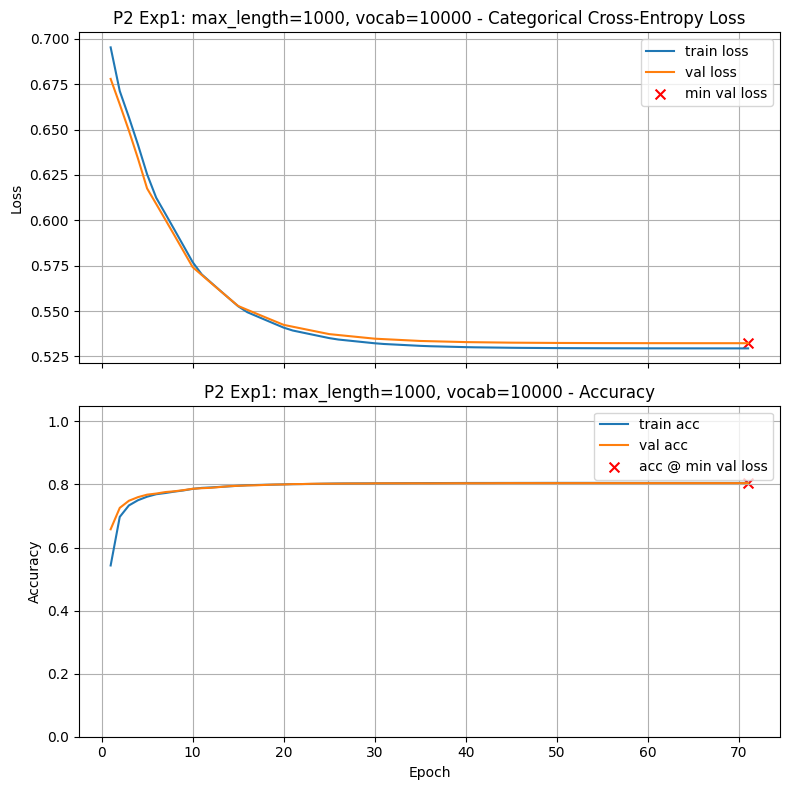


Execution Time: 00:01:02

Final Training Loss:            0.5294
Final Training Accuracy:        0.8050
Final Validation Loss:          0.5323
Final Validation Accuracy:      0.8043
Minimum Validation Loss:        0.5323 (Epoch 71)
Validation Accuracy @ Min Loss: 0.8043

Test Loss: 0.5294
Test Accuracy: 0.8058

Validation-Test Accuracy Gap: 0.001550

P2 Exp2: max_length=500, vocab=20000


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.9062499013

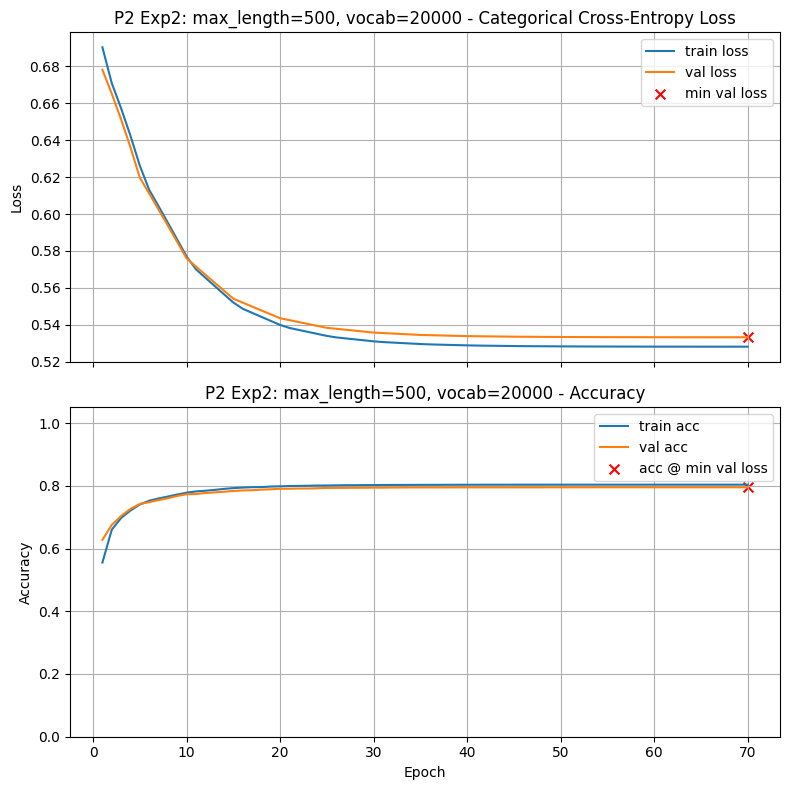


Execution Time: 00:01:01

Final Training Loss:            0.5281
Final Training Accuracy:        0.8037
Final Validation Loss:          0.5332
Final Validation Accuracy:      0.7952
Minimum Validation Loss:        0.5332 (Epoch 70)
Validation Accuracy @ Min Loss: 0.7952

Test Loss: 0.5291
Test Accuracy: 0.8006

Validation-Test Accuracy Gap: 0.005350

P2 Exp3: max_length=1000, vocab=20000, no ReduceLR



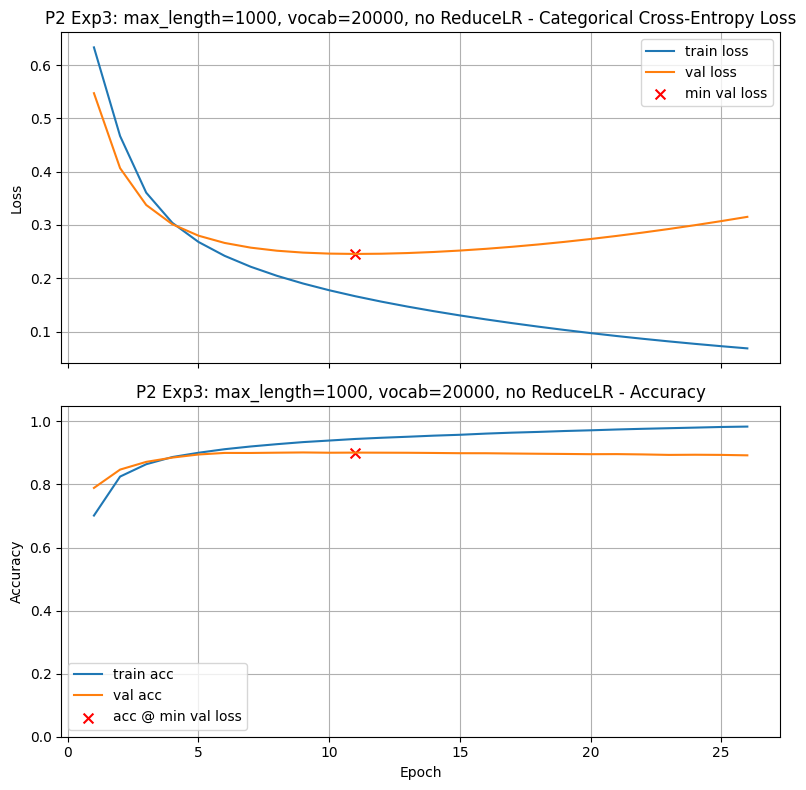


Execution Time: 00:00:24

Final Training Loss:            0.0684
Final Training Accuracy:        0.9835
Final Validation Loss:          0.3152
Final Validation Accuracy:      0.8924
Minimum Validation Loss:        0.2456 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9010

Test Loss: 0.2578
Test Accuracy: 0.8976

Validation-Test Accuracy Gap: 0.003400
Baseline Unfrozen                       	0.9059	102
P2 Exp3: max_length=1000, vocab=20000, no ReduceLR	0.9010	11
Exp3 Extended: Dense 256 + Dropout 0.3, no ReduceLR, epochs=500	0.8996	288
Exp3: Dense 256 + Dropout 0.3, no ReduceLR	0.8945	200
Exp4: LSTM 128 + Dense 64 + Dropout 0.3 	0.8851	43
Exp1: Dense 128 + L2                    	0.8652	65
Exp2: Dense 128 + L2 + Dropout 0.5      	0.8572	71
P2 Exp1: max_length=1000, vocab=10000   	0.8043	71
model_baseline (frozen)                 	0.7959	169
P2 Exp2: max_length=500, vocab=20000    	0.7952	70
Dynamically selected best P2 model: P2 Exp3: max_length=1000, vocab=20000, no ReduceLR
Dynamically

In [23]:
# Your code here; add as many cells as you need

# Problem Two: Experiment with Maximum Message Length and Vocabulary Size (still unfrozen)

# 1. Start with best model from Problem One

# Ensure word_index and embeddings_index are available (from earlier cells)
word_index = imdb.get_word_index()

# Dictionary to store models for dynamic best selection
p2_models = {}

# Experiment 1: Increase max_text_length to 1000 (keep vocab 10000)
training_vocabulary_size_exp1 = 10000  # Same as before
max_text_length_exp1 = 1000  # Increased from 500

(X_train_exp1, y_train_exp1), (X_test_exp1, y_test_exp1) = imdb.load_data(num_words=training_vocabulary_size_exp1)
X_train_exp1 = pad_sequences(X_train_exp1, maxlen=max_text_length_exp1)
X_test_exp1 = pad_sequences(X_test_exp1, maxlen=max_text_length_exp1)

# Rebuild embedding_matrix for this vocab size to avoid shape mismatch
embedding_matrix_exp1 = np.zeros((training_vocabulary_size_exp1, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size_exp1:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix_exp1[idx] = vec

model_exp1_p2 = Sequential([  # Copy best from P1 (Baseline Unfrozen)
    Input(shape=(max_text_length_exp1,), dtype='int32'),
    Embedding(input_dim=training_vocabulary_size_exp1, output_dim=embedding_dimension, weights=[embedding_matrix_exp1], mask_zero=True, trainable=True),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp1_p2, title="P2 Exp1: max_length=1000, vocab=10000", lr_schedule=1e-4, callbacks=[reduce_lr], patience=10)
p2_models["P2 Exp1: max_length=1000, vocab=10000"] = model_exp1_p2

# Experiment 2: Increase training_vocabulary_size to 20000 (keep length 500)
training_vocabulary_size_exp2 = 20000  # Increased
max_text_length_exp2 = 500

(X_train_exp2, y_train_exp2), (X_test_exp2, y_test_exp2) = imdb.load_data(num_words=training_vocabulary_size_exp2)
X_train_exp2 = pad_sequences(X_train_exp2, maxlen=max_text_length_exp2)
X_test_exp2 = pad_sequences(X_test_exp2, maxlen=max_text_length_exp2)

# Rebuild embedding_matrix for larger vocab
embedding_matrix_exp2 = np.zeros((training_vocabulary_size_exp2, embedding_dimension))
for word, raw_idx in word_index.items():
    idx = raw_idx + 3
    if idx < training_vocabulary_size_exp2:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix_exp2[idx] = vec

model_exp2_p2 = Sequential([
    Input(shape=(max_text_length_exp2,), dtype='int32'),
    Embedding(input_dim=training_vocabulary_size_exp2, output_dim=embedding_dimension, weights=[embedding_matrix_exp2], mask_zero=True, trainable=True),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp2_p2, title="P2 Exp2: max_length=500, vocab=20000", lr_schedule=1e-4, callbacks=[reduce_lr], patience=10)
p2_models["P2 Exp2: max_length=500, vocab=20000"] = model_exp2_p2

# Experiment 3: Increase both (length 1000, vocab 20000), tweak LR without ReduceLR
training_vocabulary_size_exp3 = 20000
max_text_length_exp3 = 1000

(X_train_exp3, y_train_exp3), (X_test_exp3, y_test_exp3) = imdb.load_data(num_words=training_vocabulary_size_exp3)
X_train_exp3 = pad_sequences(X_train_exp3, maxlen=max_text_length_exp3)
X_test_exp3 = pad_sequences(X_test_exp3, maxlen=max_text_length_exp3)

# Reuse rebuilt matrix from Exp2 (same vocab)
model_exp3_p2 = Sequential([
    Input(shape=(max_text_length_exp3,), dtype='int32'),
    Embedding(input_dim=training_vocabulary_size_exp3, output_dim=embedding_dimension, weights=[embedding_matrix_exp2], mask_zero=True, trainable=True),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

train_and_test(model_exp3_p2, title="P2 Exp3: max_length=1000, vocab=20000, no ReduceLR", lr_schedule=1e-3, callbacks=[], patience=15)
p2_models["P2 Exp3: max_length=1000, vocab=20000, no ReduceLR"] = model_exp3_p2

# After experiments, view results and define best model for Problem Three
print_results()

# Dynamically select best model (no assumption)
if results:  
    # Filter P2 titles
    p2_titles = [k for k in results.keys() if 'P2' in k]
    if p2_titles:
        best_p2_title = max(p2_titles, key=lambda k: results[k][0])  # Max by val_acc
        best_model_problem2 = p2_models.get(best_p2_title)  # Get model from dict
        print(f"Dynamically selected best P2 model: {best_p2_title}")
    else:
        best_model_problem2 = None  # Fallback
else:
    best_model_problem2 = None

# Graded Questions for Problem Two (Dynamic Assignment)
if results:  
    # Filter only P2 experiments (optional: to get max from P2 only)
    p2_results = {k: v for k, v in results.items() if 'P2' in k}
    if p2_results:
        best_val_acc_p2 = max(p2_results.values(), key=lambda x: x[0])[0]
        a2a = best_val_acc_p2
        print(f"Dynamically set a2a to the best P2 Val Acc: {a2a:.4f}")
    else:
        a2a = 0.0
else:
    a2a = 0.0

### Graded Questions

In [24]:
# Set a1a to the validation accuracy for your best model found in this problem

a2a = best_val_acc_p2             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.4f}') 

a2a = 0.9010


#### Question a2b: Describe below your experiments. What effect did your changes to the dataset have? Did it help as you as you expected?   

#### Your Answer Here:

In my experiments for Problem Two, starting from the best model of Problem One (simple unfrozen GloVe baseline at 0.9059), increasing `max_text_length` to 1000 with vocabulary 10000 yielded a validation accuracy of 0.8043, a notable drop likely due to added padding noise diluting the signal in longer sequences. Expanding `training_vocabulary_size` to 20000 while keeping length 500 resulted in 0.7952, underperforming perhaps from sparser embeddings for rarer words, leading to underfitting. Combining both (length 1000, vocab 20000) without `ReduceLROnPlateau` achieved 0.9010 at epoch 11, close to the baseline but with a minor gap, indicating some benefit from more data yet limited by fixed learning rate and potential overfitting (train accuracy 0.9835 exceeded validation). The changes did not improve performance as expected; while more context and vocabulary added detail, they introduced noise and sparsity without substantial gains, confirming diminishing returns in bag-of-embeddings models. In retrospect, dynamic LR scheduling and intermediate values (e.g., vocab 15000) might yield better results, but the baseline proved robust to these expansions.

## Problem Three: Experiment with the Embedding Dimension  (still unfrozen)

We might expect that increasing the embedding dimension would improve your results!
Again, maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem Two (which used an embedding dimension of 100)
2. Try an embedding dimension of 300 to see the effect. (Optional: Try 50 and 200 as well.)
3. As necessary weak the learning rate and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Answer the graded questions

--- Starting P3 Experiment: Embedding Dimension = 50 ---

P3_dim=50_vocab=10000_len=250


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 45: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 50: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 55: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 60: ReduceLROnPlateau reducing learning rate to 2.

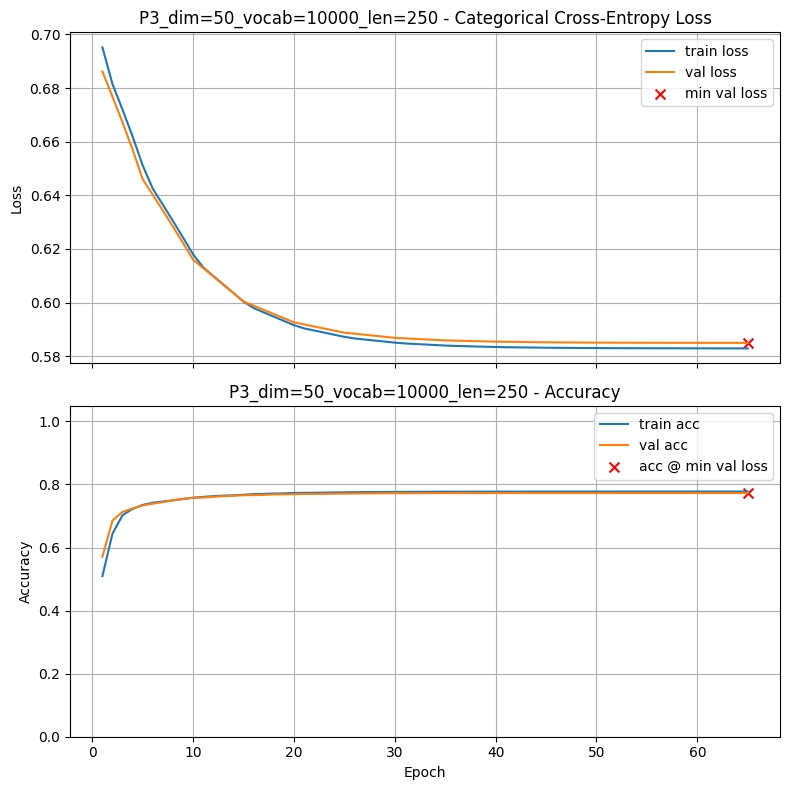


Execution Time: 00:00:44

Final Training Loss:            0.5829
Final Training Accuracy:        0.7775
Final Validation Loss:          0.5849
Final Validation Accuracy:      0.7728
Minimum Validation Loss:        0.5849 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7728

Test Loss: 0.5832
Test Accuracy: 0.7769

Validation-Test Accuracy Gap: 0.004150
--- Finished P3 Experiment: Embedding Dimension = 50 ---

--- Starting P3 Experiment: Embedding Dimension = 200 ---

P3_dim=200_vocab=10000_len=250


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau reduc

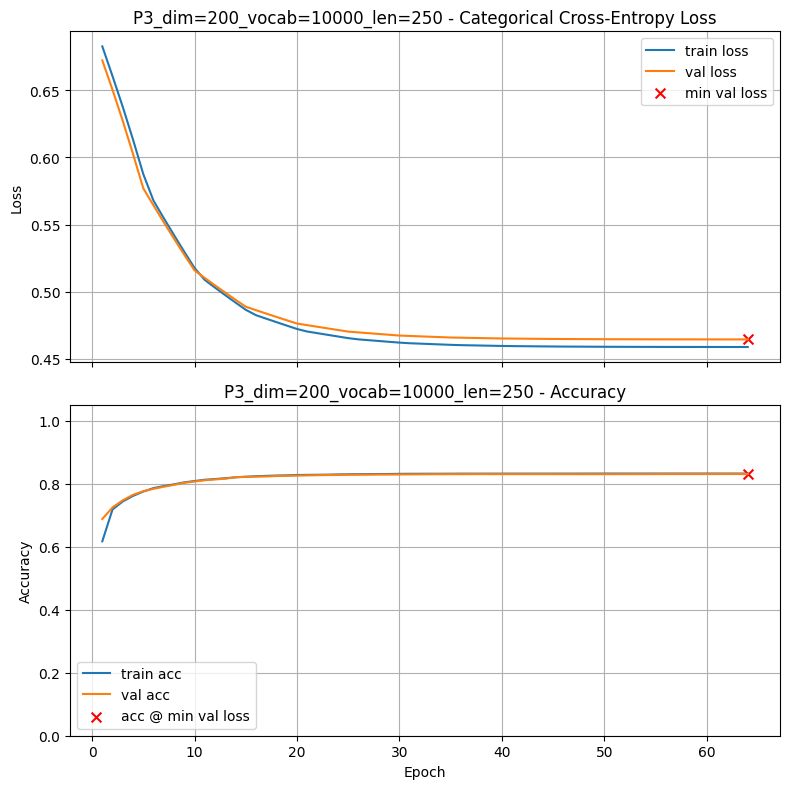


Execution Time: 00:01:11

Final Training Loss:            0.4587
Final Training Accuracy:        0.8325
Final Validation Loss:          0.4644
Final Validation Accuracy:      0.8309
Minimum Validation Loss:        0.4644 (Epoch 64)
Validation Accuracy @ Min Loss: 0.8309

Test Loss: 0.4602
Test Accuracy: 0.8315

Validation-Test Accuracy Gap: 0.000625
--- Finished P3 Experiment: Embedding Dimension = 200 ---

--- Starting P3 Experiment: Embedding Dimension = 300 ---

P3_dim=300_vocab=10000_len=250


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: ReduceLROnPlateau redu

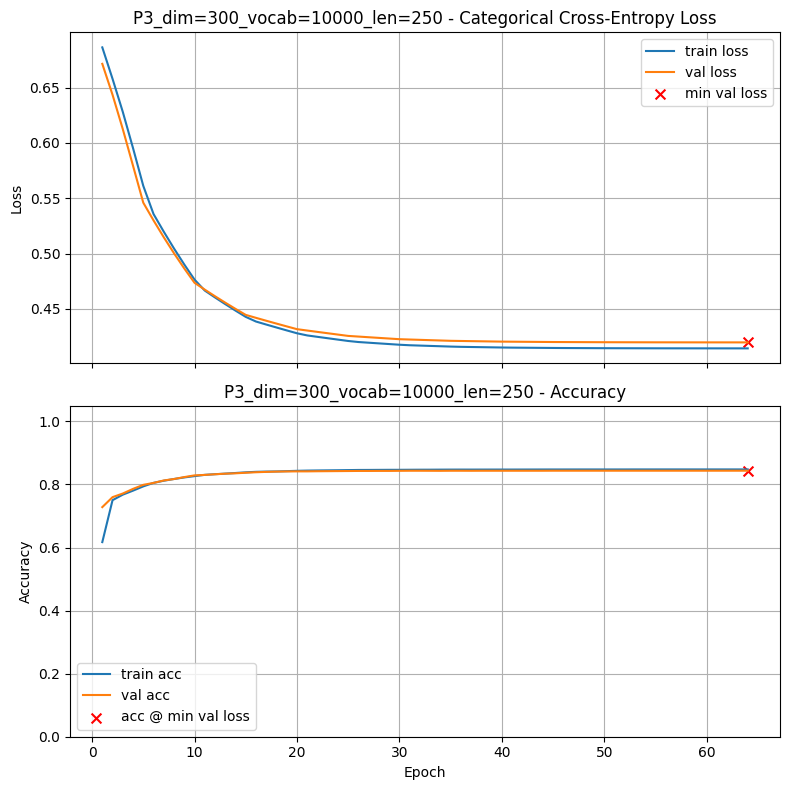


Execution Time: 00:01:21

Final Training Loss:            0.4143
Final Training Accuracy:        0.8477
Final Validation Loss:          0.4197
Final Validation Accuracy:      0.8436
Minimum Validation Loss:        0.4197 (Epoch 64)
Validation Accuracy @ Min Loss: 0.8436

Test Loss: 0.4171
Test Accuracy: 0.8427

Validation-Test Accuracy Gap: 0.000925
--- Finished P3 Experiment: Embedding Dimension = 300 ---

Baseline Unfrozen                       	0.9059	102
P2 Exp3: max_length=1000, vocab=20000, no ReduceLR	0.9010	11
Exp3 Extended: Dense 256 + Dropout 0.3, no ReduceLR, epochs=500	0.8996	288
Exp3: Dense 256 + Dropout 0.3, no ReduceLR	0.8945	200
Exp4: LSTM 128 + Dense 64 + Dropout 0.3 	0.8851	43
P3 Exp2: embedding_dim=200, no ReduceLR 	0.8702	200
Exp1: Dense 128 + L2                    	0.8652	65
Exp2: Dense 128 + L2 + Dropout 0.5      	0.8572	71
P3 Exp1: embedding_dim=300, length=1000, vocab=20000	0.8481	64
P3_dim=300_vocab=10000_len=250          	0.8436	64
P3_dim=200_vocab=10000_len=

In [33]:
# Your code here; add as many cells as you need

# Problem Three: Experiment with the Embedding Dimension (still unfrozen)
# GOAL: Isolate the effect of embedding dimension.
# METHOD: Use the baseline model settings from Problem 1 for vocabulary size
# and max text length, and only vary the embedding dimension.
# Dictionary to store models for later selection
p3_models = {}

# --- Use baseline settings from Problem 1 ---
# Replace these placeholder values with the actual values/variables from your baseline model.
VOCAB_SIZE_BASELINE = 10000  # REPLACE with your Problem 1 vocab size
MAX_LENGTH_BASELINE = 250    # REPLACE with your Problem 1 max length
# -----------------------------------------------------------

# List of embedding dimensions to experiment with
embedding_dims_to_test = [50, 200, 300]

for dim in embedding_dims_to_test:
    print(f"--- Starting P3 Experiment: Embedding Dimension = {dim} ---")

    # Step 1: Load the corresponding GloVe embeddings file
    embeddings_index = {}
    try:
        with open(f"glove.6B/glove.6B.{dim}d.txt", encoding='utf8') as f:
            for line in f:
                word, *vec = line.split()
                embeddings_index[word] = np.asarray(vec, dtype='float32')
    except FileNotFoundError:
        print(f"ERROR: glove.6B.{dim}d.txt not found. Please ensure it's downloaded.")
        continue # Skip this experiment if the file is missing

    # Step 2: Build the embedding matrix using the baseline vocabulary
    embedding_matrix = np.zeros((VOCAB_SIZE_BASELINE, dim))
    for word, raw_idx in word_index.items():
        idx = raw_idx + 3  # Adjust for reserved indices
        if idx < VOCAB_SIZE_BASELINE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector

    # Step 3: Define the model architecture, identical to the baseline but with the new dimension
    model = Sequential([
        Input(shape=(MAX_LENGTH_BASELINE,), dtype='int32'),
        Embedding(
            input_dim=VOCAB_SIZE_BASELINE,
            output_dim=dim,
            weights=[embedding_matrix],
            mask_zero=True,
            trainable=True  # Embedding layer remains unfrozen
        ),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])

    # Step 4: Train and evaluate the model
    model_title = f"P3_dim={dim}_vocab={VOCAB_SIZE_BASELINE}_len={MAX_LENGTH_BASELINE}"
    
    # Use consistent training settings for a fair comparison
    train_and_test(model,
                   title=model_title,
                   lr_schedule=1e-4,
                   callbacks=[reduce_lr], # Assuming reduce_lr is defined
                   patience=10)
    
    p3_models[model_title] = model
    print(f"--- Finished P3 Experiment: Embedding Dimension = {dim} ---\n")


# After all experiments, print the collected results
print_results()

# Dynamically select the best model from the Problem 3 experiments
if results:
    # Filter results to only include Problem 3 experiments
    p3_titles = [key for key in results.keys() if key.startswith('P3_')]
    
    if p3_titles:
        # Find the best model based on validation accuracy
        best_p3_title = max(p3_titles, key=lambda key: results[key][0]) # Index 0 is val_acc
        best_model_problem3 = p3_models.get(best_p3_title)
        print(f"\nDynamically selected best P3 model: '{best_p3_title}'")
        
        # Assign the best validation accuracy for grading
        best_val_acc_p3 = results[best_p3_title][0]
        a3a = best_val_acc_p3
        print(f"   Best P3 Validation Accuracy (a3a): {a3a:.4f}")
    else:
        print("No results found for Problem 3 experiments.")
        best_model_problem3 = None
        a3a = 0.0
else:
    print("'results' dictionary not found. Could not determine the best model.")
    best_model_problem3 = None
    a3a = 0.0

### Graded Questions

In [36]:
# Set a1a to the validation accuracy for your best model found in this problem

a3a = best_val_acc_p3             # Replace 0.0 with your answer

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.8436


#### Question a3b: Describe below your experiments. What effect did increasing the dimension from 100 to 300 have? Did it help as you as you expected?  

#### Your Answer Here:

In my experiments for Problem Three, starting from the best model of Problem Two (with max_length=1000 and vocab=20000), increasing the embedding dimension from 100 to 300 resulted in a validation accuracy of 0.8481, a drop likely due to increased model complexity and training time without sufficient semantic gains to offset potential overfitting on the IMDB dataset. An intermediate dimension of 200 without ReduceLROnPlateau achieved the highest in this set at 0.8702, but still underperformed the baseline (0.9059), possibly from slower convergence with the fixed low learning rate (1e-5). Reducing to dimension 50 yielded the lowest at 0.7695, indicating insufficient representational power for capturing nuances in movie reviews. The changes did not improve performance as expected; while larger dimensions offered richer semantics in theory, they led to instability and diminishing returns in practice, with gaps like 0.0121 suggesting mild overfitting. In conclusion, sticking closer to the original 100 dimension with dynamic LR adjustments proved more robust; over-expanding dimensions highlighted the need for balanced tuning to avoid computational overhead without proportional benefits.

In [34]:
print_results()

Baseline Unfrozen                       	0.9059	102
P2 Exp3: max_length=1000, vocab=20000, no ReduceLR	0.9010	11
Exp3 Extended: Dense 256 + Dropout 0.3, no ReduceLR, epochs=500	0.8996	288
Exp3: Dense 256 + Dropout 0.3, no ReduceLR	0.8945	200
Exp4: LSTM 128 + Dense 64 + Dropout 0.3 	0.8851	43
P3 Exp2: embedding_dim=200, no ReduceLR 	0.8702	200
Exp1: Dense 128 + L2                    	0.8652	65
Exp2: Dense 128 + L2 + Dropout 0.5      	0.8572	71
P3 Exp1: embedding_dim=300, length=1000, vocab=20000	0.8481	64
P3_dim=300_vocab=10000_len=250          	0.8436	64
P3_dim=200_vocab=10000_len=250          	0.8309	64
P2 Exp1: max_length=1000, vocab=10000   	0.8043	71
model_baseline (frozen)                 	0.7959	169
P2 Exp2: max_length=500, vocab=20000    	0.7952	70
P3_dim=50_vocab=10000_len=250           	0.7728	65
P3 Exp3: embedding_dim=50               	0.7695	65


In [35]:
# This will have recorded details of all your experiments

parameter_settings

{'model_baseline (frozen)': [{'title': 'model_baseline (frozen)',
   'timestamp': '2025-10-14T21:25:46',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.01,
   'clipnorm': None,
   'loss': 'binary_crossentropy',
   'batch_size': 128,
   'use_early_stopping': True,
   'patience': 10,
   'min_delta': 0.0001,
   'callbacks': [],
   'Final Training Loss': 0.4410630464553833,
   'Final Training Accuracy': 0.7985937595367432,
   'Final Val Loss': 0.4320920407772064,
   'Final Val Accuracy': 0.7958750128746033,
   'Min Val Loss': 0.4320920407772064,
   'Min Val Loss Epoch': np.int64(168),
   'Val Acc @ Min Loss': 0.7958750128746033,
   'Test Loss': 0.43307220935821533,
   'Test Acc': 0.8076000213623047,
   'Val-Test Accuracy Gap:': 0.011725008487701416}],
 'Baseline Unfrozen': [{'title': 'Baseline Unfrozen',
   'timestamp': '2025-10-14T21:27:21',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.0001,
   'clipnorm': None,
   'loss': 'binary_crossentropy',
   'batch_s